# Tasks
This notebook is for conducting an analysis, no finite plots will be constructed here.


* Insulation score analysis
    * Get insulations scores (IS)
    * Do ANOVA (or t-test) for IS
    * Conduct functional analysis GSEA (MSIGDB, KEGG, REACTOME, GO:BP)

# Uploads

In [18]:
import numpy as np
import pandas as pd
import cooler
import pyranges as pr
 
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns

from glob import glob
#from importlib import reload
import gffpandas.gffpandas as gffpd

from utils.anova import *
from utils.gene_intervals import bins_to_genes_intersection

In [2]:
#crucial work dirs
COOLER_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC'
DOWNSAMPLED_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/downsampled'
INSULATION_PATH = '/tank/projects/kriukov_chromatin/HIC/insulation'
COMPARTMENTS_PATH = '/tank/projects/kriukov_chromatin/HIC/compartments'
GENOME_FOLDER_PATH = '/tank/projects/kriukov_chromatin/GENOME'

In [73]:
#import genes
gffpath = '%s/GCF_000001635.27_GRCm39_genomic.gff' % GENOME_FOLDER_PATH
annot_path = '%s/GCF_000001635.27_GRCm39_assembly_report.txt' % GENOME_FOLDER_PATH
#refseq to chrom annotation
annotation = gffpd.read_gff3(gffpath)
fasta_annot = pd.read_csv(annot_path, sep='\t', skiprows=28)
refseq2chrom = dict(zip(fasta_annot['RefSeq-Accn'].values, fasta_annot['UCSC-style-name'].values))
gn = annotation.attributes_to_columns()
gn.seq_id = gn.seq_id.map(refseq2chrom)
gn['length'] = gn['end'] - gn['start']
gn = gn[['seq_id', 'source', 'type', 'start', 'end', 'score', 'strand',
         'ID', 'Name', 'description', 'length', 'chromosome']]

#types of sequences
gn_code = gn[gn['type']=='gene'] #protein codeing
gn_lnc = gn[gn['type']=='lnc_RNA'] #long non-coding
gn_trna = gn[gn['type']=='tRNA'] #tRNA
gn_rrna = gn[gn['type']=='rRNA'] #rRNA

In [41]:
gn = annotation.attributes_to_columns()

In [63]:
gn.seq_id.unique()

array(['NC_000067.7', 'NT_166280.1', 'NT_166281.1', 'NT_166282.1',
       'NT_162750.1', 'NW_023337852.1', 'NT_166338.1', 'NC_000068.8',
       'NC_000069.7', 'NC_000070.7', 'NT_187055.1', 'NC_000071.7',
       'NT_187056.1', 'NT_187057.1', 'NT_187058.1', 'NT_166438.1',
       'NT_187059.1', 'NC_000072.7', 'NC_000073.7', 'NT_166307.1',
       'NC_000074.7', 'NC_000075.7', 'NC_000076.7', 'NC_000077.7',
       'NC_000078.7', 'NC_000079.7', 'NC_000080.7', 'NC_000081.7',
       'NC_000082.7', 'NC_000083.7', 'NC_000084.7', 'NC_000085.7',
       'NC_000086.8', 'NT_165789.3', 'NC_000087.8', 'NT_187060.1',
       'NT_187061.1', 'NT_187062.1', 'NT_187063.1', 'NT_166451.1',
       'NT_166462.1', 'NT_166465.1', 'NT_166466.1', 'NT_166467.1',
       'NT_166469.1', 'NT_166474.1', 'NT_166476.1', 'NT_166478.1',
       'NT_166443.1', 'NT_166444.1', 'NT_166480.1', 'NT_166456.1',
       'NT_166471.1', 'NT_166473.1', 'NT_166454.1', 'NT_166463.1',
       'NT_166450.1', 'NT_166452.1', 'NT_187064.1', 'NW_023

In [5]:
!ls /tank/projects/kriukov_chromatin/HIC/insulation

IS_50000.csv


In [74]:
#insulation score
IS = pd.read_csv('%s/IS_50000.csv' % INSULATION_PATH, index_col=0)

# Insulation score analysis

In [75]:
explore = ['WT', 'young', 'old']
mask = np.array([any([e in c for e in explore]) for c in IS.columns])

X = IS.drop(IS.columns[~mask], 1).T
X = X.dropna(axis=1)

y = [d.split('_')[0] for d in X.index] #0-for age; 1-for sex

types_dict = {'WT':'Y', 'young':'Y', 'old':'old', 'KO':'KO'}
y = [types_dict[t] for t in y]
print(y)

['Y', 'Y', 'Y', 'old', 'old', 'old', 'Y', 'Y', 'Y']


/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


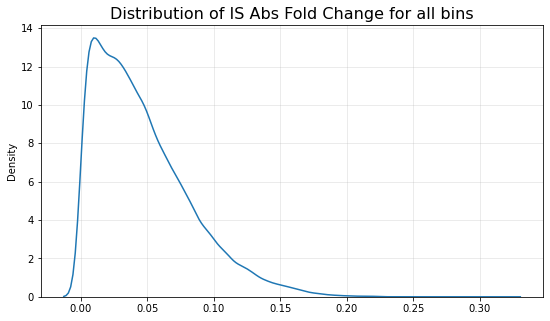

Total number of features: 42953
Number of p_values <= 0.030: 7762
Number of p_values after FDR correction: 1


,14283
WT_female_2,0.413791
WT_female_3,0.409935
WT_male_1,0.433262
old_female_2,0.539883
old_female_3,0.534430
old_male_1,0.524549
young_female_2,0.425943
young_female_3,0.423855
young_male_1,0.417796


In [76]:
anova = ANOVA(X, y, 0.03)
anova.get_filter_distribution('FC')

a, b = anova.make_anova()
anova.get_passed_features()

100%|██████████| 50/50 [00:40<00:00,  1.23it/s]


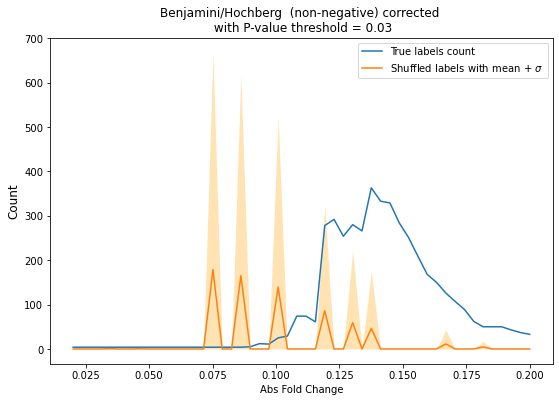

0.13755102040816328

In [78]:
anova.make_permutation_search('FC', interval=(0.02, 0.2), steps=50, N=15, **{'ddof':1})
anova.plot_permutation_results()
anova.get_best_criterion()

In [79]:
X_s, P_s = anova.get_passed_features_for_some_criterion(criterion=anova.get_best_criterion(), 
                                                        return_pvals=True)
P_adj_s_sorted = np.sort(P_s[1][P_s[0]])
X_s_sorted = X_s.iloc[:, np.argsort(P_s[1][P_s[0]])]

#extract intervals and p_values, take top N bins
X_passed_intervals = IS.loc[X_s_sorted.columns][['chrom', 'start', 'end']]
X_passed_intervals['p_adj'] = P_adj_s_sorted

print("Bins passed: %d" % X_passed_intervals.shape[0])

Bins passed: 363


In [80]:
X_top = X_passed_intervals#.iloc[:top, :]

#intersection with genes
significant_genes = bins_to_genes_intersection(X_top[['chrom', 'start', 'end']], gn_code)

In [91]:
significant_genes

,Chromosome,Start,End,Start_b,End_b,source,type,score,strand,ID,Name,description,length,chromosome
0,chr1,22356196,22845239,22600000,22650000,BestRefSeq%2CGnomon,gene,.,-,gene-Rims1,Rims1,regulating synaptic membrane exocytosis 1,489043,None
1,chr1,22356196,22845239,22650000,22700000,BestRefSeq%2CGnomon,gene,.,-,gene-Rims1,Rims1,regulating synaptic membrane exocytosis 1,489043,None
2,chr1,22356196,22845239,22700000,22750000,BestRefSeq%2CGnomon,gene,.,-,gene-Rims1,Rims1,regulating synaptic membrane exocytosis 1,489043,None
3,chr1,22356196,22845239,22750000,22800000,BestRefSeq%2CGnomon,gene,.,-,gene-Rims1,Rims1,regulating synaptic membrane exocytosis 1,489043,None
4,chr1,22356196,22845239,22800000,22850000,BestRefSeq%2CGnomon,gene,.,-,gene-Rims1,Rims1,regulating synaptic membrane exocytosis 1,489043,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,chrX,101891237,101900813,101850000,101900000,BestRefSeq%2CGnomon,gene,.,-,gene-Dmrtc1c2,Dmrtc1c2,DMRT-like family C1c2,9576,None
630,chrX,160500032,160562490,160550000,160600000,BestRefSeq,gene,.,+,gene-Rai2,Rai2,retinoic acid induced 2,62458,None
631,chrX,160597689,160615118,160550000,160600000,BestRefSeq%2CGnomon,gene,.,-,gene-Scml1,Scml1,Scm polycomb group protein like 1,17429,None
632,chrX,160597689,160615118,160600000,160650000,BestRefSeq%2CGnomon,gene,.,-,gene-Scml1,Scml1,Scm polycomb group protein like 1,17429,None


In [ ]:
EXPLORES = [['young', 'KO'], ['WT', 'KO'], ['old', 'KO']]
top = 750

for explore in tqdm(EXPLORES):
    ### Data filtering
    fname = '::'.join(explore)
    mask = np.array([any([e in c for e in explore]) for c in df.columns])
    X = df.drop(df.columns[~mask], 1).T
    X = X.dropna(axis=1)
    y = [d.split('_')[0] for d in X.index] #0-for age; 1-for sex
    
    ### ANOVA
    anova = ANOVA(X, y, 0.02)
    p, pcor = anova.make_anova()
    anova.make_permutation_search('FC', interval=(0.02, 0.2), steps=50, N=15, **{'ddof':1})
    X_s, P_s = anova.get_passed_features_for_some_criterion(criterion=anova.get_best_criterion(), 
                                                            return_pvals=True)
    #plot
    anova.plot_permutation_results(savename='Insulation/' + fname + '_FC.png')
    
    P_adj_s_sorted = np.sort(P_s[1][P_s[0]])
    X_s_sorted = X_s.iloc[:, np.argsort(P_s[1][P_s[0]])]
    
    #extract intervals and p_values, take top N bins
    X_passed_intervals = IS_info.loc[X_s_sorted.columns][['chrom', 'start', 'end']]
    X_passed_intervals['p_adj'] = P_adj_s_sorted
    X_top = X_passed_intervals.iloc[:top, :]
    
    #intersection with genes
    significant_genes = bins_to_genes_intersection(X_top[['chrom', 'start', 'end']], genes)
    print('Found %d genes in top %d bins' % (len(significant_genes), top))
    significant_genes.to_csv('Insulation/found_genes_with_absFC_criterion_at_%s_%d.csv' % (fname, top))